In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import numpy as np
import os
os.chdir('..')

import torch_converter as tc
import instance_generator as ig
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from util import NumpyDataset, Dataset
from evaluate import evaluate_model, pp_output
import evaluate as ev
from gnn_library.OBM_greedy import OBM_Greedy
import pickle


%load_ext autoreload
%autoreload 2

def graph_config_to_string(config):
    graph_type = config['graph_type']
    if graph_type == 'ER':
        return f"ER_{config['p']}"
    if graph_type == 'BA':
        return f"BA_{config['ba_param']}"
    if graph_type == 'GEOM':
        return f"GEOM_{config['q']}"
    if graph_type == 'GM':
        return "GM"
    if graph_type == 'OSMNX':
        return f"OSMNX_{config['location']}"

def save_meta_experiment(graph_str, data):
    with open(f"experiments/meta_{graph_str}.pickle", 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def upload_meta_experiment(graph_str, data):
    filepath = f"experiments/meta_{graph_str}.pickle"
    try:
        with open(filepath, 'rb') as handle:
            current_data = pickle.load(handle)
        
        for model in current_data.keys():
            if model == 'num_trials':
                current_data[model] += data[model]
            else:
                for i in range(len(current_data[model])):
                    current_data[model][i].extend(data[model][i])

        with open(filepath, 'wb') as handle:
            pickle.dump(current_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    except:
        with open(filepath, 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_meta_experiments(configs):
    data = {}
    for config in configs:
        config_str = graph_config_to_string(config)
        with open(f"experiments/meta_{config_str}.pickle", 'rb') as handle:
            data[config_str] = pickle.load(handle)
    return data


import scipy.stats as st 


In [51]:
def title_of_graph_type(graph_type):
    if 'ER' in graph_type:
        return f"ER, p={graph_type[3:]}"
    if 'GM' in graph_type:
        return "gMission"
    if 'OSMNX' in graph_type:
        return f"Rideshare, {graph_type[6:-17]}"
    if 'BA' in graph_type:
        return f"BA, b={graph_type[3:]}"
    else:
        return f"b-RGG, q={graph_type[5:]}"
    
label_map = {
    'meta_no_greedy': 'MAGNOLIA (meta)',
    'greedy': 'greedy',
    'greedy_t': 'greedy-t',
    'lp_rounding': 'LP-rounding',
    'meta_threshold': 'threshold (meta)'
}
    
    
color_map = {
    'meta_no_greedy': '#ff1f5b',
    'greedy': '#009ade',
    'greedy_t': '#af58ba',
    'lp_rounding': '#00cd6c',
    'meta_threshold': '#F9812A'
}

def _plot_approx_ratios(ratios, data, naming_function = lambda graph_type: graph_type, x_axis_name = "$\\vert R \\vert \; / \; \\vert L \\vert$ regime", confidence = 0.95):
    num_subplots = len(data.keys())
    fig, ax = plt.subplots(1, num_subplots, sharex=True, sharey=True, figsize=(12,3))
    fig.add_subplot(111, frameon=False)
    i = 0
    for graph_type, graph_data in data.items():
        avg_ratios = {}

        for model, cr_by_ratio in graph_data.items():
            if model != 'num_trials':
                avg_ratios[model] = []
                for raw_crs in cr_by_ratio:
                    mean = np.mean(raw_crs)
                    ci_lb, ci_ub = st.norm.interval(
                        alpha=0.95, 
                        loc=mean, 
                        scale=st.sem(raw_crs)
                    )
                    avg_ratios[model].append((mean, ci_lb, ci_ub))

        for model, model_ratios in avg_ratios.items():
            if model in ['meta_no_greedy', 'greedy', 'greedy_t', 'lp_rounding']:
                competitive_ratios = [val[0] for val in model_ratios]
                ci_lbs = [val[1] for val in model_ratios]
                ci_ubs = [val[2] for val in model_ratios]
                ax[i].plot(ratios, competitive_ratios, label=label_map[model], color=color_map[model])
                ax[i].fill_between(ratios, ci_lbs, ci_ubs, alpha = 0.2, color=color_map[model])
                ax[i].grid(visible=True, which='both', axis='both')
                ax[i].set_title(title_of_graph_type(graph_type), fontsize=17)
                ax[i].tick_params(axis='both', which='major', labelsize=13)
                ax[i].tick_params(axis='both', which='minor', labelsize=13)
                handles, labels = ax[i].get_legend_handles_labels()

        i += 1

    order = [3, 0, 1, 2]
    fig.legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        bbox_to_anchor=(1.14, 0.25),
        loc='lower right',
        fontsize=15
    )
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(x_axis_name, fontsize = 18, labelpad=20)
    plt.ylabel('Average competitive ratio', fontsize = 20, labelpad=15)
    plt.savefig(f"data/meta_example_plots.pdf", dpi=300, bbox_inches = "tight")
    plt.show()

# 0.09

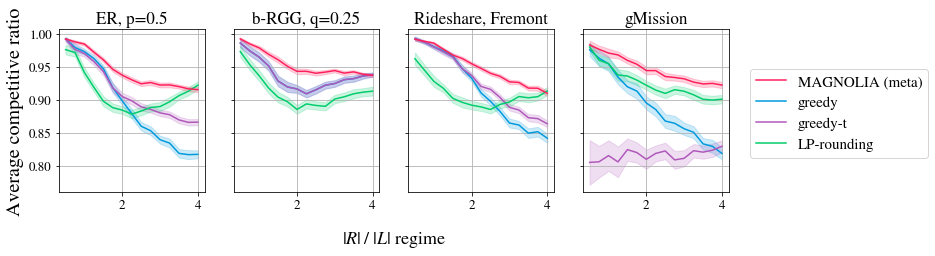

In [52]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["text.usetex"] = False

select_meta_configs = [
    {
        'graph_type': 'ER',
        'p': 0.5,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.25,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'OSMNX',
        'location': 'Fremont, California, USA'
    },
    {
        'graph_type': 'GM'
    },
]

test = load_meta_experiments(select_meta_configs)
node_configs = [(x, 16) for x in np.arange(8, 65, 4)]
ratios = [x/y for (x,y) in node_configs]
_plot_approx_ratios(ratios, test, lambda graph_type: graph_type, confidence = 0.95)

In [53]:
def _plot_approx_ratios2(ratios, data, naming_function = lambda graph_type: graph_type, x_axis_name = "$\\vert R \\vert \; / \; \\vert L \\vert$ regime", confidence = 0.95):
    fig, ax = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(12,16))
    fig.add_subplot(111, frameon=False)
    i = 0
    j = 0
    for graph_type, graph_data in data.items():
        avg_ratios = {}

        for model, cr_by_ratio in graph_data.items():
            if model != 'num_trials':
                avg_ratios[model] = []
                for raw_crs in cr_by_ratio:
                    mean = np.mean(raw_crs)
                    ci_lb, ci_ub = st.norm.interval(
                        alpha=0.95, 
                        loc=mean, 
                        scale=st.sem(raw_crs)
                    )
                    avg_ratios[model].append((mean, ci_lb, ci_ub))

        for model, model_ratios in avg_ratios.items():
            if model in ['meta_no_greedy', 'greedy', 'greedy_t', 'lp_rounding']:
                competitive_ratios = [val[0] for val in model_ratios]
                ci_lbs = [val[1] for val in model_ratios]
                ci_ubs = [val[2] for val in model_ratios]
                ax[i, j].plot(ratios, competitive_ratios, label=label_map[model], color=color_map[model])
                ax[i, j].fill_between(ratios, ci_lbs, ci_ubs, alpha = 0.2, color=color_map[model])
                ax[i, j].grid(visible=True, which='both', axis='both')
                ax[i, j].set_title(title_of_graph_type(graph_type), fontsize=17)
                ax[i, j].tick_params(axis='both', which='major', labelsize=13)
                ax[i, j].tick_params(axis='both', which='minor', labelsize=13)
                handles, labels = ax[i, j].get_legend_handles_labels()

        j += 1
        if j == 3:
            i += 1
            j = 0

    order = [3, 0, 1, 2]
    fig.legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        bbox_to_anchor=(1.22, 0.5),
        loc='right',
        fontsize=20
    )
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(x_axis_name, fontsize = 20, labelpad=15)
    plt.ylabel('Average competitive ratio', fontsize = 20, labelpad=15)
    plt.savefig(f"data/meta_complete_plots.pdf", dpi=300, bbox_inches = "tight")
    plt.show()

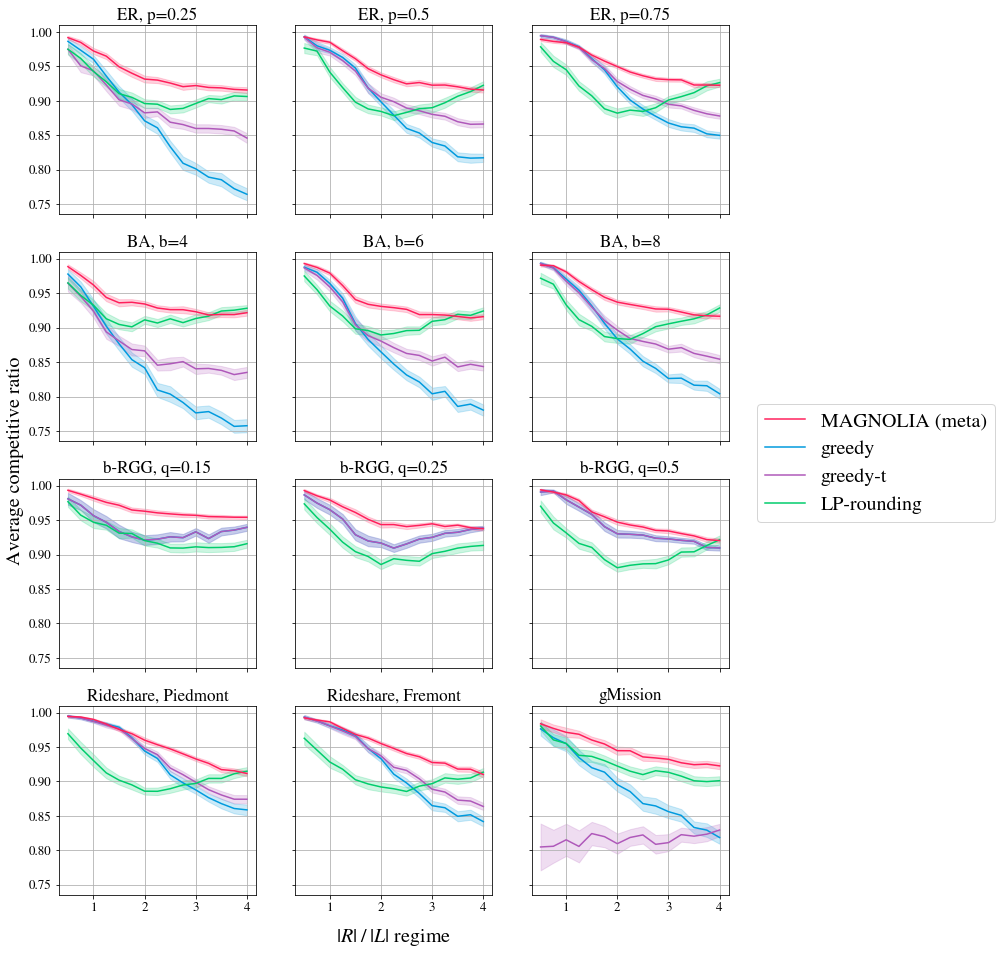

In [54]:
graph_configs = [
    {
        'graph_type': 'ER',
        'p': 0.25,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.5,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 6,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 8,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.15,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.25,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.5,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'OSMNX',
        'location': 'Piedmont, California, USA'
    },
    {
        'graph_type': 'OSMNX',
        'location': 'Fremont, California, USA'
    },
    {
        'graph_type': 'GM'
    },
]

test = load_meta_experiments(graph_configs)
node_configs = [(x, 16) for x in np.arange(8, 65, 4)]
ratios = [x/y for (x,y) in node_configs]
_plot_approx_ratios2(ratios, test, lambda graph_type: graph_type, confidence = 0.95)

In [55]:
def _plot_approx_ratios3(ratios, data, naming_function = lambda graph_type: graph_type, x_axis_name = "$\\vert R \\vert \; / \; \\vert L \\vert$ regime", confidence = 0.95):
    fig, ax = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(12,16))
    
    fig.add_subplot(111, frameon=False)
    i = 0
    j = 0
    for graph_type, graph_data in data.items():
        avg_ratios = {}

        for model, cr_by_ratio in graph_data.items():
            if model != 'num_trials':
                avg_ratios[model] = []
                for raw_crs in cr_by_ratio:
                    mean = np.mean(raw_crs)
                    ci_lb, ci_ub = st.norm.interval(
                        alpha=0.95, 
                        loc=mean, 
                        scale=st.sem(raw_crs)
                    )
                    avg_ratios[model].append((mean, ci_lb, ci_ub))

        for model, model_ratios in avg_ratios.items():
            if model in ['meta_no_greedy', 'meta_threshold']:
                competitive_ratios = [val[0] for val in model_ratios]
                ci_lbs = [val[1] for val in model_ratios]
                ci_ubs = [val[2] for val in model_ratios]
                ax[i, j].plot(ratios, competitive_ratios, label=label_map[model], color=color_map[model])
                ax[i, j].fill_between(ratios, ci_lbs, ci_ubs, alpha = 0.2, color=color_map[model])
                ax[i, j].grid(visible=True, which='both', axis='both')
                ax[i, j].set_title(title_of_graph_type(graph_type), fontsize=17)
                ax[i, j].tick_params(axis='both', which='major', labelsize=13)
                ax[i, j].tick_params(axis='both', which='minor', labelsize=13)
                #ax[i].set_ylim([0.76, 1.01])
                handles, labels = ax[i, j].get_legend_handles_labels()

        j += 1
        if j == 3:
            i += 1
            j = 0

    order = [0, 1]
    fig.legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        bbox_to_anchor=(1.22, 0.5),
        loc='right',
        fontsize=20
    )
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(x_axis_name, fontsize = 20, labelpad=15)
    plt.ylabel('Average competitive ratio', fontsize = 20, labelpad=15)
    plt.savefig(f"data/meta_ablation_plots.pdf", dpi=300, bbox_inches = "tight")
    plt.show()

In [56]:
graph_configs = [
    {
        'graph_type': 'ER',
        'p': 0.25,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.5,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 6,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 8,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.15,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.25,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.5,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'OSMNX',
        'location': 'Piedmont, California, USA'
    },
    {
        'graph_type': 'OSMNX',
        'location': 'Fremont, California, USA'
    },
    {
        'graph_type': 'GM'
    },
]

test = load_meta_experiments(graph_configs)
node_configs = [(x, 16) for x in np.arange(8, 65, 4)]
ratios = [x/y for (x,y) in node_configs]
_plot_approx_ratios3(ratios, test, lambda graph_type: graph_type, confidence = 0.95)